# Monte Carlo Simulations for Heat in Place

Heat in Place Results:
P90: 27617302991.06 MJ
P50: 33047543797.92 MJ
P10: 39137820006.01 MJ


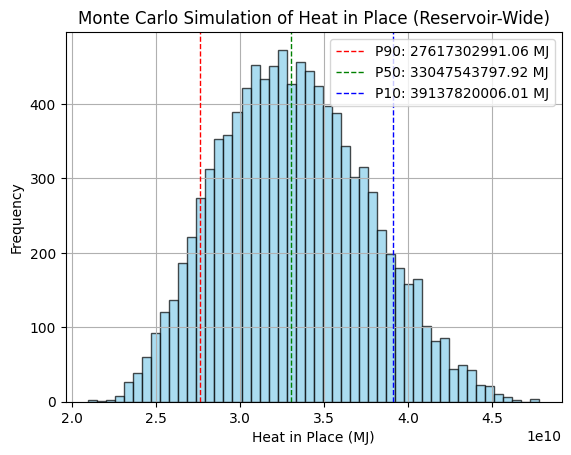


Example Water Flow Calculation:
Mass Flow Rate: 238.10 kg/s
Volumetric Flow Rate: 0.2506 m^3/s


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Assign wells to production and reinjection groups
production_wells = ["Known_LONCCARICA_1", "Known_REZOVACCKE_KRCCEVINE_1", 
                    "Known_REZOVACCKE_KRCCEVINE_2", "Known_SUHOPOLJE_1"]
reinjection_wells = ["Unknown_Well1", "Unknown_Well2", 
                     "Known_VIROVITICA_1", "Known_VIROVITICA_3ALFA"]

# Example average properties from production wells (from previous code or manual input)
# In practice, derive these from your data and predictions.
reservoir_area_range = [2.0e6, 2.2e6]          # m^2 (e.g., from geospatial data)
reservoir_thickness_range = [50, 70]            # m
rock_density_range = [2600, 2700]               # kg/m^3
rock_specific_heat_range = [850, 950]           # J/kg-K
fluid_density_range = [900, 1000]               # kg/m^3 for liquid water at ~200°C
fluid_specific_heat_range = [4200, 4300]        # J/kg-K for water
average_reservoir_temp_range = [140, 160]       # °C (example: from well logs or ML predictions)
reinjection_temp_range = [40, 60]               # °C (cooled fluid)
porosity_range = [0.14, 0.16]                     # fraction (just an example)

# Monte Carlo simulation settings
num_simulations = 10000

# Draw random samples for each parameter
reservoir_area = np.random.uniform(*reservoir_area_range, num_simulations)
reservoir_thickness = np.random.uniform(*reservoir_thickness_range, num_simulations)
porosity = np.random.uniform(*porosity_range, num_simulations)
rock_density = np.random.uniform(*rock_density_range, num_simulations)
rock_specific_heat = np.random.uniform(*rock_specific_heat_range, num_simulations)
fluid_density = np.random.uniform(*fluid_density_range, num_simulations)
fluid_specific_heat = np.random.uniform(*fluid_specific_heat_range, num_simulations)
average_reservoir_temp = np.random.uniform(*average_reservoir_temp_range, num_simulations)
reinjection_temp = np.random.uniform(*reinjection_temp_range, num_simulations)

# Calculate Heat In Place (HIP)
# HIP = ( (1 - phi)*rho_rock*C_rock + phi*rho_fluid*C_fluid ) * Volume * (T_res - T_reinj)
# Volume = Area * Thickness
# Results in Joules; we can convert to MJ by dividing by 1e6
volume = reservoir_area * reservoir_thickness  # m^3
heat_capacity_mix = ((1 - porosity)*rock_density*rock_specific_heat +
                     porosity*fluid_density*fluid_specific_heat)  # J/m^3-K

delta_T = average_reservoir_temp - reinjection_temp  # K (approx since °C difference is same as K difference)
heat_in_place = heat_capacity_mix * volume * delta_T  # Joules
heat_in_place_mj = heat_in_place / 1e6  # Convert to MJ

# Calculate P90, P50, and P10 values
p90 = np.percentile(heat_in_place_mj, 10)
p50 = np.percentile(heat_in_place_mj, 50)
p10 = np.percentile(heat_in_place_mj, 90)

# Print out the results
print("Heat in Place Results:")
print(f"P90: {p90:.2f} MJ")
print(f"P50: {p50:.2f} MJ")
print(f"P10: {p10:.2f} MJ")

# Plot a histogram
plt.hist(heat_in_place_mj, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(p90, color='red', linestyle='dashed', linewidth=1, label=f'P90: {p90:.2f} MJ')
plt.axvline(p50, color='green', linestyle='dashed', linewidth=1, label=f'P50: {p50:.2f} MJ')
plt.axvline(p10, color='blue', linestyle='dashed', linewidth=1, label=f'P10: {p10:.2f} MJ')
plt.title("Monte Carlo Simulation of Heat in Place (Reservoir-Wide)")
plt.xlabel("Heat in Place (MJ)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


##############################################################
# Simple Method for Calculating Water Flow Rate
##############################################################

def calculate_water_flow(power_output_MWe, fluid_density, fluid_specific_heat, inlet_temp, outlet_temp, efficiency=0.1):
    """
    Estimate water flow rate required given a desired power output.
    This is a simplified calculation that assumes a certain thermodynamic efficiency and 
    constant fluid properties.

    Parameters:
    - power_output_MWe: Desired electrical power output in MWe (1 MWe = 1 MW electric).
    - fluid_density: Density of the geothermal fluid (kg/m^3).
    - fluid_specific_heat: Specific heat capacity of the fluid (J/kg-K).
    - inlet_temp: Inlet (reservoir) temperature of the fluid (°C or K).
    - outlet_temp: Outlet (reinjection) temperature of the fluid (°C or K).
    - efficiency: Conversion efficiency from thermal power to electrical power (fraction).

    Returns:
    - mass_flow_rate (kg/s): The required mass flow rate of water.
    - volumetric_flow_rate (m^3/s): The required volumetric flow rate of water.
    """
    # Convert MWe to W (Watts)
    power_output_W = power_output_MWe * 1e6

    # Thermal power needed: P_th = P_el / efficiency
    thermal_power_needed = power_output_W / efficiency  # J/s

    # Available enthalpy per kg of fluid: C_fluid * (T_in - T_out)
    delta_h = fluid_specific_heat * (inlet_temp - outlet_temp)  # J/kg

    # mass_flow_rate * delta_h = thermal_power_needed
    mass_flow_rate = thermal_power_needed / delta_h  # kg/s

    # volumetric_flow_rate = mass_flow_rate / density
    volumetric_flow_rate = mass_flow_rate / fluid_density  # m^3/s

    return mass_flow_rate, volumetric_flow_rate


# Example usage of water flow calculation
# Suppose we want 10 MWe output, fluid properties from our ranges:
example_power_output = 10.0  # MWe
example_fluid_density = 950  # kg/m^3 (approx)
example_fluid_spec_heat = 4200  # J/kg-K
inlet_temp = 150  # °C
outlet_temp = 50   # °C
example_efficiency = 0.1

m_flow, v_flow = calculate_water_flow(example_power_output,
                                      example_fluid_density,
                                      example_fluid_spec_heat,
                                      inlet_temp,
                                      outlet_temp,
                                      example_efficiency)

print("\nExample Water Flow Calculation:")
print(f"Mass Flow Rate: {m_flow:.2f} kg/s")
print(f"Volumetric Flow Rate: {v_flow:.4f} m^3/s")


In [28]:
# Given P90 HIP in MJ
p90_hip = 27617302991.06  # MJ

# Assumptions / Inputs
plant_lifetime_years = 25           # How many years you plan to operate
annual_operating_hours = 7800       # Hours per year plant runs
efficiency = 0.15                   # Power conversion efficiency (10% assumed)
electricity_price = 168.00          # EUR/MWh (just an example, from your spreadsheet)

# Start with a trial capacity or test multiple capacities
# Let's try a range of capacities to see what fraction of HIP they require
test_capacities = [1, 2, 4, 5]   # MWe (just examples)

for capacity in test_capacities:
    # Calculate total electricity produced over the lifetime
    total_electricity_MWh = capacity * annual_operating_hours * plant_lifetime_years
    # Convert MWh to MJ: 1 MWh = 3,600 MJ
    total_electricity_MJ = total_electricity_MWh * 3600.0

    # Thermal energy needed = Electrical energy / efficiency
    total_thermal_MJ = total_electricity_MJ / efficiency

    # Compare with HIP
    hip_ratio = total_thermal_MJ / p90_hip

    print(f"--- Capacity: {capacity} MWe ---")
    print(f"Total Electricity (over {plant_lifetime_years} years): {total_electricity_MWh:.2f} MWh")
    print(f"Thermal Energy Required: {total_thermal_MJ:.2f} MJ")
    print(f"P90 HIP: {p90_hip:.2f} MJ")
    print(f"Ratio (Thermal Needed / HIP): {hip_ratio:.2f}")

    if hip_ratio < 1.0:
        print("This capacity seems feasible based on HIP (total thermal need is less than HIP).")
    else:
        print("This capacity may be too high, as it requires more thermal energy than HIP.")
    print()

# You can also pick one capacity and print the economics:
chosen_capacity = 2  # MWe, for example
total_electricity_MWh = chosen_capacity * annual_operating_hours * plant_lifetime_years
total_electricity_MJ = total_electricity_MWh * 3600.0
total_thermal_MJ = total_electricity_MJ / efficiency
revenue = total_electricity_MWh * electricity_price  # EUR over the lifetime (very simplistic)

print("=== Detailed Calculation for Chosen Capacity ===")
print(f"Chosen Capacity: {chosen_capacity} MWe")
print(f"Total Electricity Produced Over {plant_lifetime_years} years: {total_electricity_MWh:.2f} MWh")
print(f"Thermal Energy Required: {total_thermal_MJ:.2f} MJ")
print(f"P90 HIP: {p90_hip:.2f} MJ")
print("Ratio (Thermal Needed / HIP): {:.2f}".format(total_thermal_MJ / p90_hip))
print(f"Estimated Total Revenue (without discounting or cost considerations): {revenue:.2f} EUR")

# Next step: Adjust chosen_capacity based on results until you find a suitable balance.


--- Capacity: 1 MWe ---
Total Electricity (over 25 years): 195000.00 MWh
Thermal Energy Required: 4680000000.00 MJ
P90 HIP: 27617302991.06 MJ
Ratio (Thermal Needed / HIP): 0.17
This capacity seems feasible based on HIP (total thermal need is less than HIP).

--- Capacity: 2 MWe ---
Total Electricity (over 25 years): 390000.00 MWh
Thermal Energy Required: 9360000000.00 MJ
P90 HIP: 27617302991.06 MJ
Ratio (Thermal Needed / HIP): 0.34
This capacity seems feasible based on HIP (total thermal need is less than HIP).

--- Capacity: 4 MWe ---
Total Electricity (over 25 years): 780000.00 MWh
Thermal Energy Required: 18720000000.00 MJ
P90 HIP: 27617302991.06 MJ
Ratio (Thermal Needed / HIP): 0.68
This capacity seems feasible based on HIP (total thermal need is less than HIP).

--- Capacity: 5 MWe ---
Total Electricity (over 25 years): 975000.00 MWh
Thermal Energy Required: 23400000000.00 MJ
P90 HIP: 27617302991.06 MJ
Ratio (Thermal Needed / HIP): 0.85
This capacity seems feasible based on HIP (t

In [25]:
# Given parameters
capacity_MWe = 3.0
efficiency = 0.15
cp_water = 4200.0      # J/kg-K
delta_T = 100.0         # K (e.g. from 150°C to 50°C)
density = 1000.0        # kg/m^3

# Convert MWe to W
capacity_W = capacity_MWe * 1_000_000

# Calculate mass flow rate (kg/s)
mass_flow_kg_s = capacity_W / (cp_water * delta_T * efficiency)

# Convert to m^3/s
volumetric_flow_m3_s = mass_flow_kg_s / density

# Convert to m^3/h
volumetric_flow_m3_h = volumetric_flow_m3_s * 3600

print(f"For {capacity_MWe} MWe at {efficiency*100}% efficiency:")
print(f"Mass Flow Rate: {mass_flow_kg_s:.2f} kg/s")
print(f"Volumetric Flow Rate: {volumetric_flow_m3_h:.2f} m^3/h")

# If we have 4 production wells, flow per well:
flow_per_production_well = volumetric_flow_m3_h / 4
print(f"Flow per production well: {flow_per_production_well:.2f} m^3/h")

# Reinjection wells would also handle about the same total flow returning, divided by 4
flow_per_reinjection_well = volumetric_flow_m3_h / 4
print(f"Flow per reinjection well: {flow_per_reinjection_well:.2f} m^3/h")


For 3.0 MWe at 15.0% efficiency:
Mass Flow Rate: 47.62 kg/s
Volumetric Flow Rate: 171.43 m^3/h
Flow per production well: 42.86 m^3/h
Flow per reinjection well: 42.86 m^3/h
